In [1]:
import os
import math
import pandas as pd
import numpy as np
import seaborn as sns
import sklearn as skl
import sklearn.model_selection as model_selection
from sklearn import tree
from sklearn.ensemble import AdaBoostClassifier
import sklearn.svm as svm
import sklearn.neighbors as nbr
import sklearn.metrics as skm
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import cross_validate
from sklearn.preprocessing import OrdinalEncoder
from matplotlib.colors import ListedColormap
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
import sklearn.neural_network as nn
import tensorflow as tf

In [2]:
def cross_validate_check(learner, X, y, scoring='f1'):
    scores = cross_validate(learner, X, y, scoring=scoring)
    fit_times = scores['fit_time']
    score_times = scores['score_time']
    f1_scores = scores['test_score']
    fit_times_mean, fit_times_std = (fit_times.mean(), fit_times.std())
    score_times_mean, score_times_std = (score_times.mean(), score_times.std())
    f1_scores_mean, f1_scores_std = (f1_scores.mean(), f1_scores.std())
    means = [f1_scores_mean, score_times_mean, fit_times_mean]
    stds = [f1_scores_std, score_times_std, fit_times_std]
    
    index = ['F1 Scores', 'Score Times', 'Fit Times']

    df = pd.DataFrame(data={'Mean': means, 'Standard Deviation': stds}, index=index)
    return df


def create_confusion_matrix(y_t, y_pred, title=None, save=False, file='default.png'):
    cf_matrix = confusion_matrix(y_t, y_pred)
    group_names = ['True Neg','False Pos','False Neg','True Pos']
    group_counts = ['{0:0.0f}'.format(value) for value in
                    cf_matrix.flatten()]
    group_percentages = ['{0:.2%}'.format(value) for value in
                         cf_matrix.flatten()/np.sum(cf_matrix)]
    labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
              zip(group_names,group_counts,group_percentages)]
    labels = np.asarray(labels).reshape(2,2)
    sns.heatmap(cf_matrix, annot=labels, fmt="", cmap='Blues')
    if title:
        title = '{} Confusion Matrix'.format(title)
    else:
        title = 'Confusion Matrix'
    plt.title(title)
    if save:
        plt.savefig(file)
    plt.show()


def get_score_metrics(y, y_pred):
    accuracy = skm.accuracy_score(y, y_pred)
    precision = skm.precision_score(y, y_pred, average="macro", zero_division=0)
    recall = skm.recall_score(y, y_pred, average="macro", zero_division=0)
    f1 = skm.f1_score(y, y_pred, average="macro", zero_division=0)
    return [accuracy, precision, recall, f1]


def get_test_size_performance(learner, X, y, test_sizes):
    scores_tr = []
    scores_t = []
    for test_size in test_sizes:
        X_tr, X_t, y_tr, y_t = model_selection.train_test_split(X, y, test_size=test_size)
        X_tr = np.asarray(X_tr)
        X_t = np.asarray(X_t)
        y_tr = np.asarray(y_tr)
        y_t = np.asarray(y_t)
        pratio_tr = sum(y_tr)/len(y_tr)
        pratio_t = sum(y_t)/len(y_t)      
        
        learner.fit(X_tr, y_tr)
        y_tr_pred = learner.predict(X_tr)
        y_t_pred = learner.predict(X_t)
        y_tr_pred = np.round(y_tr_pred)
        y_t_pred = np.round(y_t_pred) 
        
        score_tr = [pratio_tr] + get_score_metrics(y_tr, y_tr_pred)
        score_t = [pratio_t] + get_score_metrics(y_t, y_t_pred)

        scores_tr.append(score_tr)
        scores_t.append(score_t)
    
    scores_tr, scores_t = list(zip(*scores_tr)), list(zip(*scores_t))
    return scores_tr, scores_t
   
    
def plot_performance(X, x_label, scores_tr, scores_t, save=False, file_tr='default_tr.png', file_t='default_t.png'):
    pratios_t, accuracy_t, precision_t, recall_t, f1_t = scores_t
    pratios_tr, accuracy_tr, precision_tr, recall_tr, f1_tr = scores_tr
    
    plt.plot(X, accuracy_t, label='Accuracy Score')
    plt.plot(X, precision_t, label='Precision Score')
    plt.plot(X, recall_t, label='Recall Score')
    plt.plot(X, f1_t, label='F1 Score')
    plt.plot(X, pratios_t, label='P Ratio', linestyle='dashed')
    plt.xlabel(x_label)
    plt.ylabel("Score")
    plt.title("Scores on Testing Sets")
    plt.legend()
    if save:
        plt.savefig(file_t)
    plt.show()
    
    plt.plot(X, accuracy_tr, label='Accuracy Score')
    plt.plot(X, precision_tr, label='Precision Score')
    plt.plot(X, recall_tr, label='Recall Score')
    plt.plot(X, f1_tr, label='F1 Score')
    plt.plot(X, pratios_tr, label='P Ratio', linestyle='dashed')
    plt.xlabel(x_label)
    plt.ylabel("Score")
    plt.title("Scores on Training Sets")
    plt.legend()
    if save:
        plt.savefig(file_tr)
    plt.show()
    

def plot_test_size_performance(X, y, test_sizes, learners: dict, save=False, dataset=''):
    for key in learners:
        print(key)
        learner = learners[key]

        file_tr = os.path.join('Figures', '{}_{}_tr_Test_Sizes.png'.format(dataset, key))
        file_t = os.path.join('Figures', '{}_{}_t_Test_Sizes.png'.format(dataset, key))

        scores_tr, scores_t = get_test_size_performance(learner, X, y, test_sizes)

        plot_performance(test_sizes, 'Test Size', scores_tr, scores_t, save=save, file_tr=file_tr, file_t=file_t)

    
def plot_parameter_performance(X, y, test_size, learner_name, learner, parameter_name, parameters, xlabel, save=False, dataset=''):
    X_tr, X_t, y_tr, y_t = model_selection.train_test_split(X, y, test_size=test_size)
    X_tr = np.asarray(X_tr)
    X_t = np.asarray(X_t)
    y_tr = np.asarray(y_tr)
    y_t = np.asarray(y_t)
    pratio_tr = sum(y_tr)/len(y_tr)
    pratio_t = sum(y_t)/len(y_t)

    scores_tr = []
    scores_t = []
    for parameter in parameters:
        setattr(learner, parameter_name, parameter)
        learner.fit(X_tr, y_tr)
        y_tr_pred = learner.predict(X_tr)
        y_t_pred = learner.predict(X_t)
        y_tr_pred = np.round(y_tr_pred)
        y_t_pred = np.round(y_t_pred)

        score_tr = [pratio_tr] + get_score_metrics(y_tr, y_tr_pred)
        score_t = [pratio_t] + get_score_metrics(y_t, y_t_pred)

        scores_tr.append(score_tr)
        scores_t.append(score_t)

    scores_tr, scores_t = list(zip(*scores_tr)), list(zip(*scores_t))
    
    file_tr = os.path.join('Figures', '{}_{}_tr_Parameters.png'.format(dataset, learner_name))
    file_t = os.path.join('Figures', '{}_{}_t_Parameters.png'.format(dataset, learner_name))
    plot_performance(parameters, xlabel, scores_tr, scores_t, save=save, file_tr=file_tr, file_t=file_t)

# CREDIT CARD DATASET

In [3]:
### IMPORT DATA INTO PANDAS DATAFRAME CALLED data
file = 'default of credit card clients.xls'
delimiter = ';'
data = pd.read_excel(file, skiprows=[0], dtype=int)

### TOTAL NUMBER OF ROWS IN RAW DATA
total_rows = data.shape[0]
total_columns = data.shape[1]

### DROP ANY ROW THAT HAS AT LEAST ONE MISSING ATTRIBUTE ENTRY
data.dropna(axis='rows', inplace=True)

total_rows = data.shape[0]
total_columns = data.shape[1]

data = data.sample(n=3000)

features = data.columns[6:12]
y = np.asarray(data['default payment next month'])
X = np.asarray(data[features].values)

900 210 0.23333333333333334
2100 446 0.2123809523809524
Tree


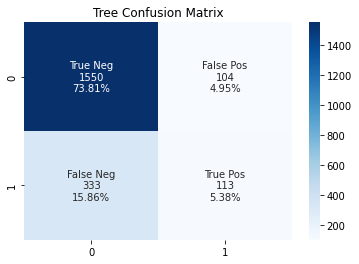

Boost


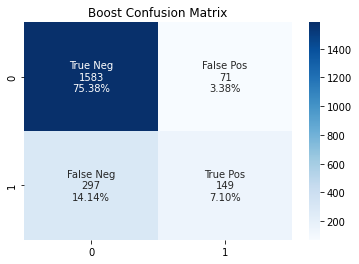

KNN


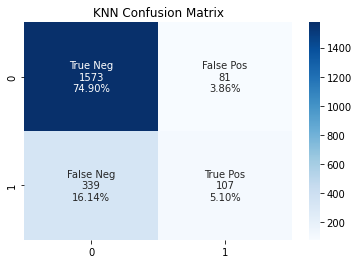

SVM


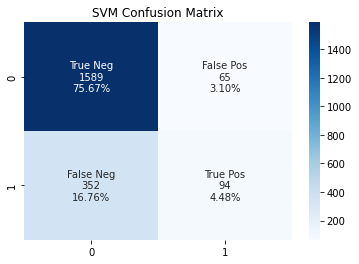

NN
29/29 [==============================] - 1s 2ms/step - loss: 0.9091 - accuracy: 0.5328


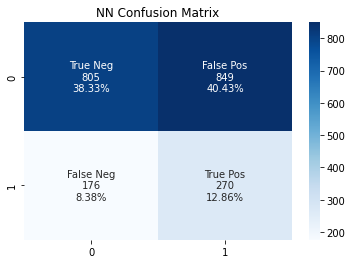

Tree


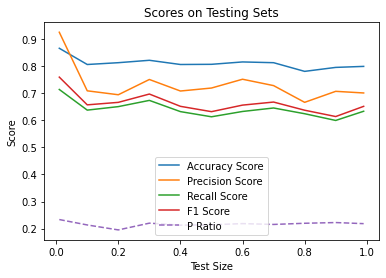

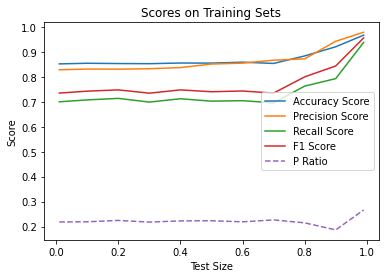

Boost


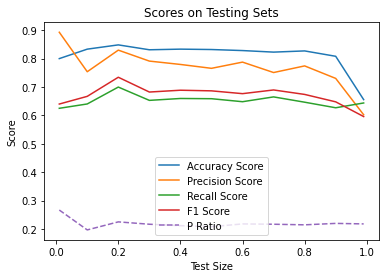

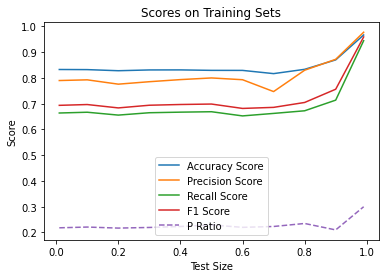

KNN


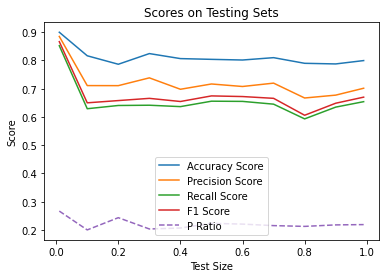

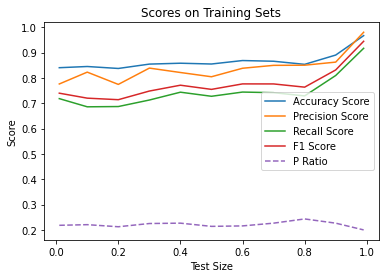

SVM


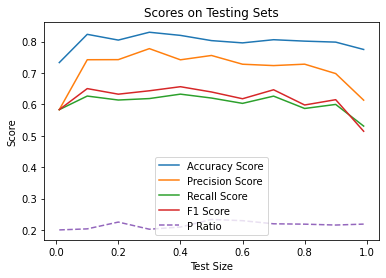

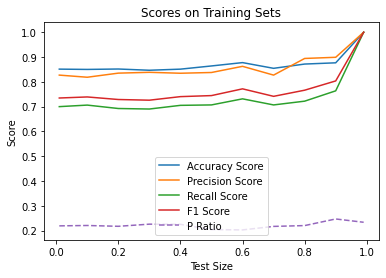

NN
1/1 [==============================] - 0s 1ms/step - loss: 0.3271 - accuracy: 0.9000


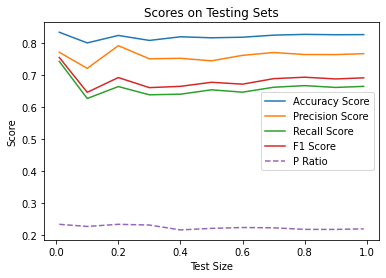

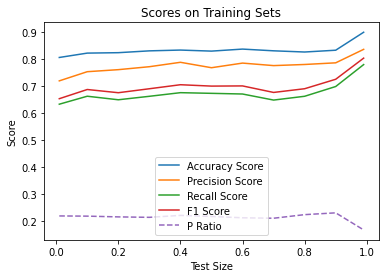

In [4]:
dataset='credit_cards'
learners = {}
learners['Tree'] = tree.DecisionTreeClassifier()
learners['Boost'] = AdaBoostClassifier(n_estimators=100)
learners['KNN'] = nbr.KNeighborsClassifier(n_neighbors=5,p=2,metric='minkowski', weights='distance')
learners['SVM'] = svm.SVC(kernel='rbf',gamma=1,C=1)

model = tf.keras.models.Sequential()
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(units=12, activation='relu'))
model.add(tf.keras.layers.Dense(units=12, activation='relu'))
model.add(tf.keras.layers.Dense(units=1, activation='sigmoid'))
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
learners['NN'] = model

X_tr, X_t, y_tr, y_t = model_selection.train_test_split(X, y, test_size=0.7)
X_tr = np.asarray(X_tr)
X_t = np.asarray(X_t)
y_tr = np.asarray(y_tr)
y_t = np.asarray(y_t)
print(len(y_tr), sum(y_tr), sum(y_tr)/len(y_tr))
print(len(y_t), sum(y_t), sum(y_t)/len(y_t))

for key in learners:
    print(key)
    learner = learners[key]
    learner.fit(X_tr, y_tr)
    y_tr_pred = learner.predict(X_tr)
    y_t_pred = learner.predict(X_t)
    y_tr_pred = np.round(y_tr_pred)
    y_t_pred = np.round(y_t_pred) 

    file_cfm = os.path.join('Figures', '{}_{}_cfm.png'.format(dataset, key))
    create_confusion_matrix(y_t, y_t_pred, title=key, save=True, file=file_cfm)
    
    if key != 'NN':
        cv = cross_validate_check(learner, X, y, scoring='f1')
        table_cv = os.path.join('Tables', '{}_{}_cv.csv'.format(dataset, key))
        cv.to_csv(table_cv)

test_sizes = [0.01, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 0.99]
plot_test_size_performance(X, y, test_sizes, learners, save=True, dataset=dataset)

KNN K Testing


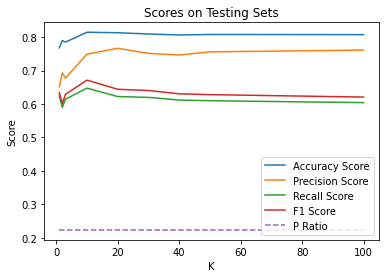

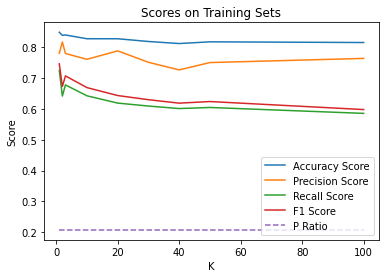

Boosting Estimators Testing


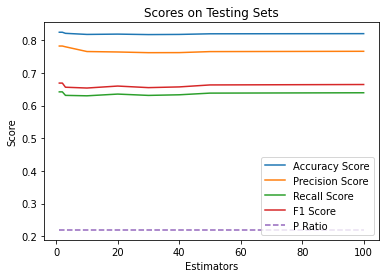

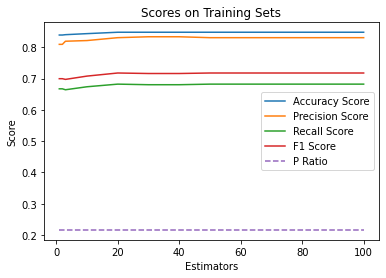

Pruning ccp_alpha Testing


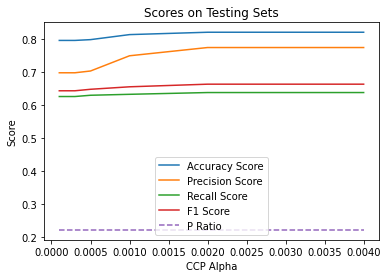

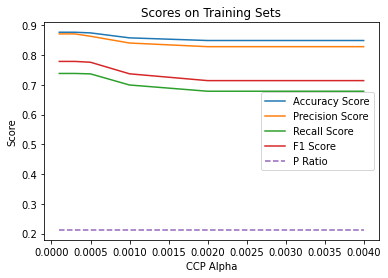

In [5]:
dataset='credit_cards'
test_size = 0.7
learner = nbr.KNeighborsClassifier(p=2,metric='minkowski', weights='uniform')
parameter_name = 'n_neighbors'
parameters = [1, 2, 3, 10, 20, 30, 40, 50, 100]
xlabel = 'K'
print('KNN K Testing')
plot_parameter_performance(X, y, test_size, 'KNN', learner, parameter_name, parameters, xlabel, save=True, dataset=dataset)

learner = AdaBoostClassifier()
parameter_name = 'n_estimators'
parameters = [1, 2, 3, 10, 20, 30, 40, 50, 100]
xlabel = 'Estimators'
print('Boosting Estimators Testing')
plot_parameter_performance(X, y, test_size, 'Boost', learner, parameter_name, parameters, xlabel, save=True, dataset=dataset)

learner = tree.DecisionTreeClassifier(random_state=0)
parameter_name = 'ccp_alpha'
parameters = [0.0001, 0.0002, 0.0003, 0.0005, 0.001, 0.002, 0.003, 0.004]
xlabel = 'CCP Alpha'
print('Pruning ccp_alpha Testing')
plot_parameter_performance(X, y, test_size, 'Tree', learner, parameter_name, parameters, xlabel, save=True, dataset=dataset)

# BANK DATASET 

In [6]:
file = 'bank.csv'
delimiter = ';'
data = pd.read_csv(file, delimiter=delimiter)

data['age'] = data['age'].map(lambda x: math.trunc(int(x)/10.))
X = data.iloc[:,:-1]
y = data['y']

enc = OrdinalEncoder()
enc.fit(X)
X = enc.transform(X)
encoder = LabelEncoder()
encoder.fit(y)
y = encoder.transform(y)

1356 168 0.12389380530973451
3165 353 0.11153238546603475
Tree


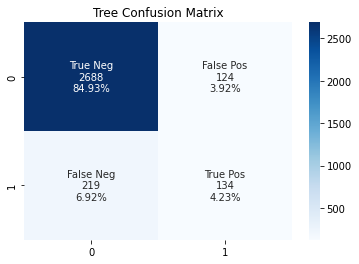

Boost


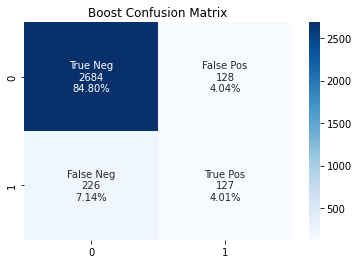

KNN


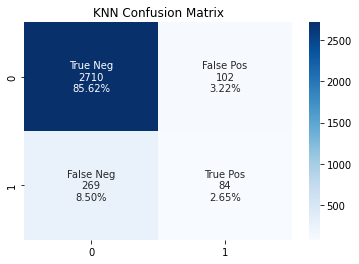

SVM


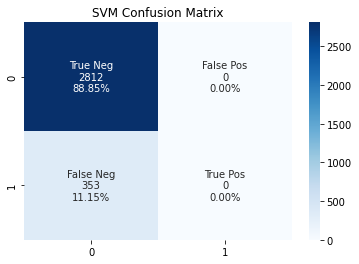

NN
43/43 [==============================] - 1s 1ms/step - loss: 214.0692 - accuracy: 0.1361


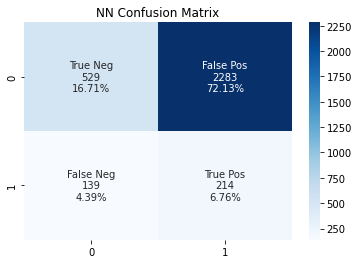

Tree


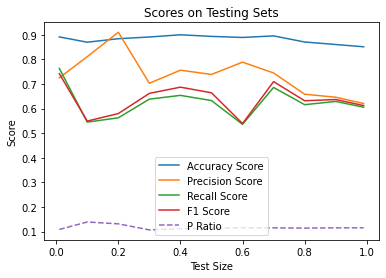

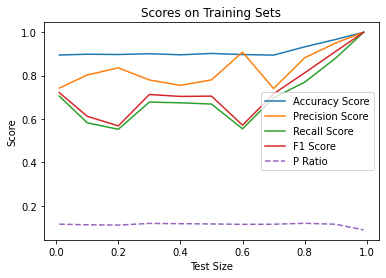

Boost


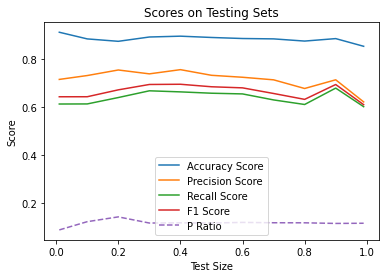

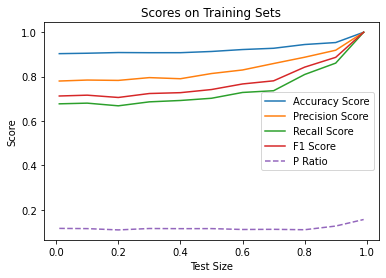

KNN


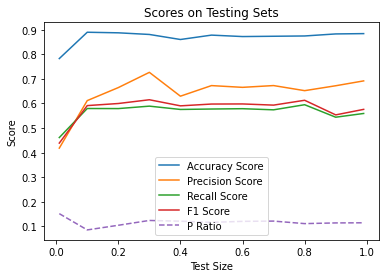

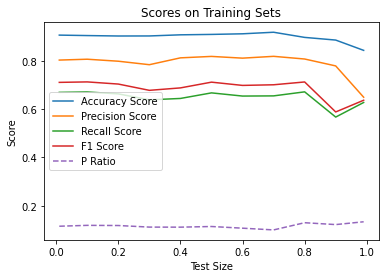

SVM


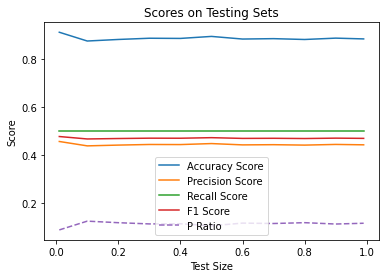

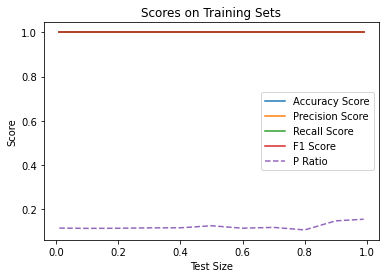

NN
2/2 [==============================] - 0s 16ms/step - loss: 0.6139 - accuracy: 0.8889


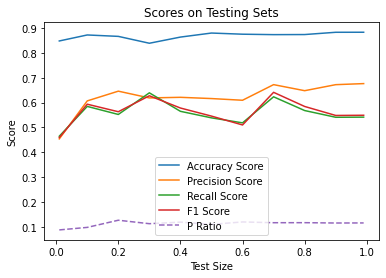

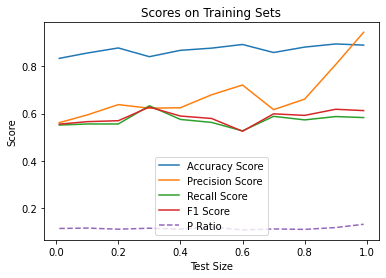

In [7]:
dataset='bank'
learners = {}
learners['Tree'] = tree.DecisionTreeClassifier(ccp_alpha=0.003)
learners['Boost'] = AdaBoostClassifier(n_estimators=100)
learners['KNN'] = nbr.KNeighborsClassifier(n_neighbors=5,p=2,metric='minkowski', weights='uniform')
learners['SVM'] = svm.SVC(kernel='rbf',gamma=1,C=1)

model = tf.keras.models.Sequential()
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(units=12, activation='relu'))
model.add(tf.keras.layers.Dense(units=12, activation='relu'))
model.add(tf.keras.layers.Dense(units=1, activation='sigmoid'))
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
learners['NN'] = model

X_tr, X_t, y_tr, y_t = model_selection.train_test_split(X, y, test_size=0.7)
X_tr = np.asarray(X_tr)
X_t = np.asarray(X_t)
y_tr = np.asarray(y_tr)
y_t = np.asarray(y_t)
print(len(y_tr), sum(y_tr), sum(y_tr)/len(y_tr))
print(len(y_t), sum(y_t), sum(y_t)/len(y_t))

for key in learners:
    print(key)
    learner = learners[key]
    learner.fit(X_tr, y_tr)
    y_tr_pred = learner.predict(X_tr)
    y_t_pred = learner.predict(X_t)
    y_tr_pred = np.round(y_tr_pred)
    y_t_pred = np.round(y_t_pred) 

    file_cfm = os.path.join('Figures', '{}_{}_bank_cfm.png'.format(dataset, key))
    create_confusion_matrix(y_t, y_t_pred, title=key, save=False, file=file_cfm)
    
    if key != 'NN':
        cv = cross_validate_check(learner, X, y, scoring='f1')
        table_cv = os.path.join('Tables', '{}_{}_bank_cv.csv'.format(dataset, key))
        cv.to_csv(table_cv)

test_sizes = [0.01, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 0.99]
plot_test_size_performance(X, y, test_sizes, learners, save=True, dataset=dataset)

KNN K Testing


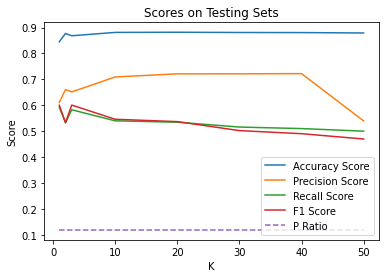

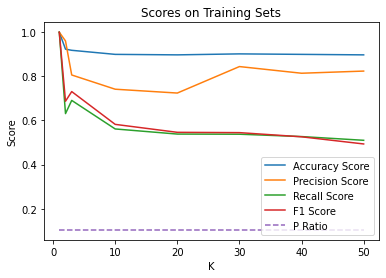

Boosting Estimators Testing


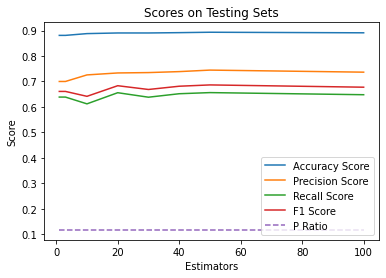

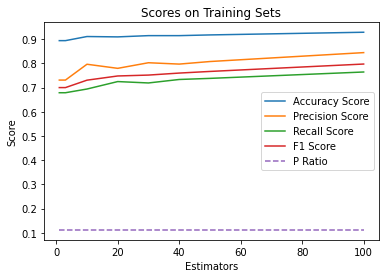

Pruning ccp_alpha Testing


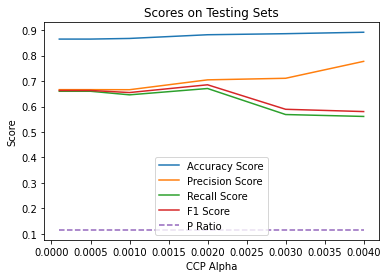

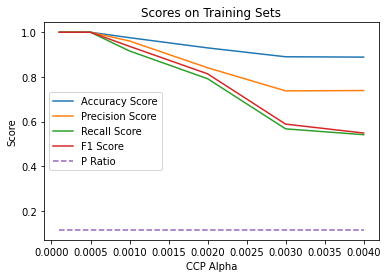

In [8]:
dataset='bank'
test_size = 0.7
learner = nbr.KNeighborsClassifier(p=2,metric='minkowski', weights='uniform')
parameter_name = 'n_neighbors'
parameters = [1, 2, 3, 10, 20, 30, 40, 50]
xlabel = 'K'
print('KNN K Testing')
plot_parameter_performance(X, y, test_size, 'KNN', learner, parameter_name, parameters, xlabel, save=True, dataset=dataset)

learner = AdaBoostClassifier()
parameter_name = 'n_estimators'
parameters = [1, 2, 3, 10, 20, 30, 40, 50, 100]
xlabel = 'Estimators'
print('Boosting Estimators Testing')
plot_parameter_performance(X, y, test_size, 'Boost', learner, parameter_name, parameters, xlabel, save=True, dataset=dataset)

learner = tree.DecisionTreeClassifier(random_state=0)
parameter_name = 'ccp_alpha'
parameters = [0.0001, 0.0002, 0.0003, 0.0005, 0.001, 0.002, 0.003, 0.004]
xlabel = 'CCP Alpha'
print('Pruning ccp_alpha Testing')
plot_parameter_performance(X, y, test_size, 'Tree', learner, parameter_name, parameters, xlabel, save=True, dataset=dataset)

Boosting Estimators Testing


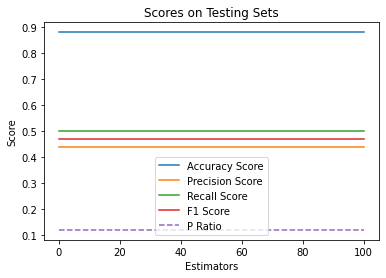

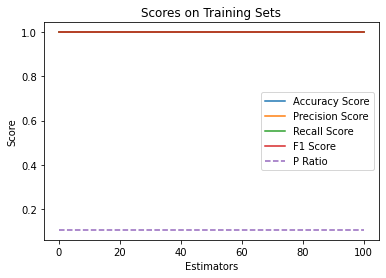

In [9]:
dataset = 'Test'
test_size = 0.7
learner = svm.SVC(kernel='rbf',gamma=1,C=1)
parameter_name = 'gamma'
parameters = [0.1, 0.2, 0.3, 1, 1.2, 2, 3, 10, 100]
xlabel = 'Estimators'
print('Boosting Estimators Testing')
plot_parameter_performance(X, y, test_size, 'Boost', learner, parameter_name, parameters, xlabel, save=False, dataset=dataset)